# 0. Imports & set-up

In [ ]:
from google.cloud import bigquery
from google.oauth2 import service_account
from google.colab import syntax

!pip install sequitur
import torch
from sequitur.models import LINEAR_AE
from sequitur import quick_train

!pip install torchinfo
from torchinfo import summary

# Mount drive - needed for GBQ creds
from google.colab import drive
drive.mount('/content/drive')

root_path = '/content/drive/MyDrive/GitHub'

credentials = service_account.Credentials.from_service_account_file(
    f'{root_path}/grav-waves/grav-waves-358320-34ebfeae2689.json', scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

client = bigquery.Client(credentials=credentials, project=credentials.project_id,)

# Authenticate
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

In [ ]:
# R-setup (for visualization)
# Problems with newer versions, still not fixed: https://stackoverflow.com/questions/74283327/conversion-py2rpy-not-defined-for-objects-of-type-class-str
!pip install rpy2==3.5.1 
%load_ext rpy2.ipython

In [ ]:
%%R

install.packages("tidyverse")
library(tidyverse)

In [ ]:
%%R 

# Packages
install.packages("sysfonts")
install.packages("extrafont")
install.packages("showtext")
install.packages("bigrquery")
library(sysfonts)
library(extrafont)
library(showtext)
library(bigrquery)
# library(tidyverse)
library(glue)

# Fonts
# font_add_google("Didact Gothic", "dg")
font_add_google("IBM Plex Sans", "ibm")

showtext_auto()
font_fam = "ibm"

# Aesthetics
purple_light <- "#d8d5f7"
purple <- "#9992DA" 
purple_dark <- "#706BA4"
grey_dark <- "#585959"

theme_light_beige <- theme(plot.background = element_rect(fill = "#F0F1EA", color = "transparent"),
      panel.background = element_rect(fill = "#F0F1EA", color = "transparent"),
      plot.margin = margin(t = "1.5", r = "1.5", b = "1.5", l = "1.5", unit = "in"),
      plot.caption = element_text(size = 12, color = "#343A41", family = font_fam),
      panel.grid = element_blank(),
      plot.title = element_text(size = 40, color = "#343A41", family = font_fam, face = "bold"),
      axis.text = element_text(size = 15, color = "#343A41", family = font_fam),
      axis.title = element_text(size = 19, color = "#343A41", family = font_fam),
      axis.ticks = element_blank(),
      legend.background = element_blank(),
      legend.position = "bottom",
      legend.title = element_text(color = "#343A41", family = font_fam),
      legend.text = element_text(color = "#343A41", family = font_fam),
      strip.background = element_rect(fill = "#343A41"),
      strip.text = element_text(color = "white", family = font_fam, face = "bold", size = 13))


theme_tech <- theme(panel.background = element_rect(fill = purple_light, color = purple_light),
        panel.grid = element_line(color = purple_light),
        strip.background = element_rect(fill = purple_dark),
        strip.text = element_text(color = "white", size = 15, face = "bold"),
        axis.ticks = element_blank(),
        axis.title = element_text(face = "bold", size = 19, color = grey_dark),
        axis.text.y = element_text(size = 15, color = grey_dark),
        # axis.text.y = element_blank(),
        axis.text.x = element_text(size = 15, color = grey_dark, face = 'bold'),
        plot.title = element_text(size = 40, color = "#343A41", family = font_fam, face = "bold"),
        legend.position = "bottom",
        legend.text = element_text(size = 15, color = grey_dark))
     

In [ ]:
# https://stackoverflow.com/questions/65876808/feeding-classifier-data-from-lstm-autoencoder
# https://curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/

# 1. Train the autoencoder

In [10]:
# Another way to pull in data; I prefer to use a SQL code chunk
waves_q = syntax.sql('''SELECT *
FROM mergers.bbh_waveforms
WHERE event IN ('GW150914', 'GW170104', 'GW190412')
AND interferometer = 'L1';''')

gw_sm = client.query(waves_q).to_dataframe()


train_seqs = []
test_seqs = []

for i in ['GW150914', 'GW170104']:

  event_pd = gw_sm.query(f'event == "{i}"')
  event_vals = event_pd['raw_value'].values[:1300]
  event_tensor = torch.from_numpy(event_vals).float()

  if i in ['GW150914', 'GW170104']:
    train_seqs.append(event_tensor)

  else:
    test_seqs.append(event_tensor)

In [41]:
# Length of examples must be a multiple of encoding_dim (size of z)
encoder, decoder, encodings, losses = quick_train(LINEAR_AE, train_seqs, encoding_dim = 500, denoise = True, verbose = False)

# z_s = []
# x_primes = []

for i in test_seqs:
  z = encoder(i) # Pass through new observation
  x_prime = decoder(z)

  # print(f'z is {z}')
  # print(f'x prime is {x_prime}')

/usr/local/lib/python3.9/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


# 2. Model summary

In [52]:
summary(encoder) # = Length of 1 example x bottleneck

Layer (type:depth-idx)                   Param #
Encoder                                  --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       650,500
│    └─Tanh: 2-2                         --
Total params: 650,500
Trainable params: 650,500
Non-trainable params: 0

In [61]:
summary(decoder) # = Length of 1 example x bottleneck + output example

Layer (type:depth-idx)                   Param #
Decoder                                  --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       651,300
Total params: 651,300
Trainable params: 651,300
Non-trainable params: 0

# 3. Evaluate model performance

In [63]:
x_prime_np = x_prime.detach().cpu().numpy()
z_np = z.detach().cpu().numpy()
x_orig = test_seqs[0].numpy()

In [69]:
len(z_np)

500

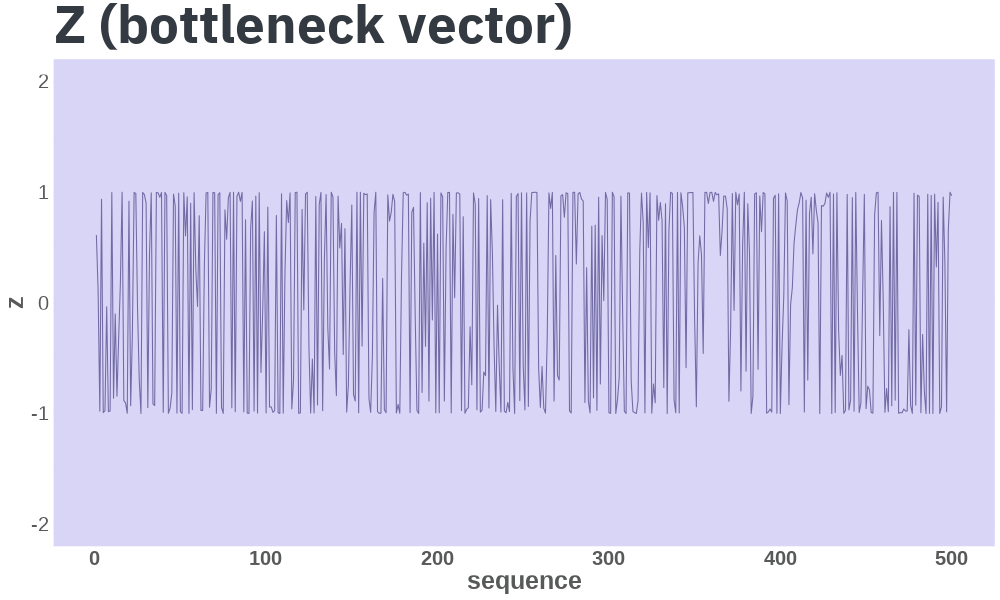

In [83]:
%%R -i z_np -h 600 -w 1000

data.frame(z = z_np,
           time = seq(1, length(z_np))) %>%
ggplot(aes(time, z)) +
geom_line(color = purple_dark) +
ylim(-2, 2) +
labs(title = 'Z (bottleneck vector)',
    x = 'sequence') +
theme_tech

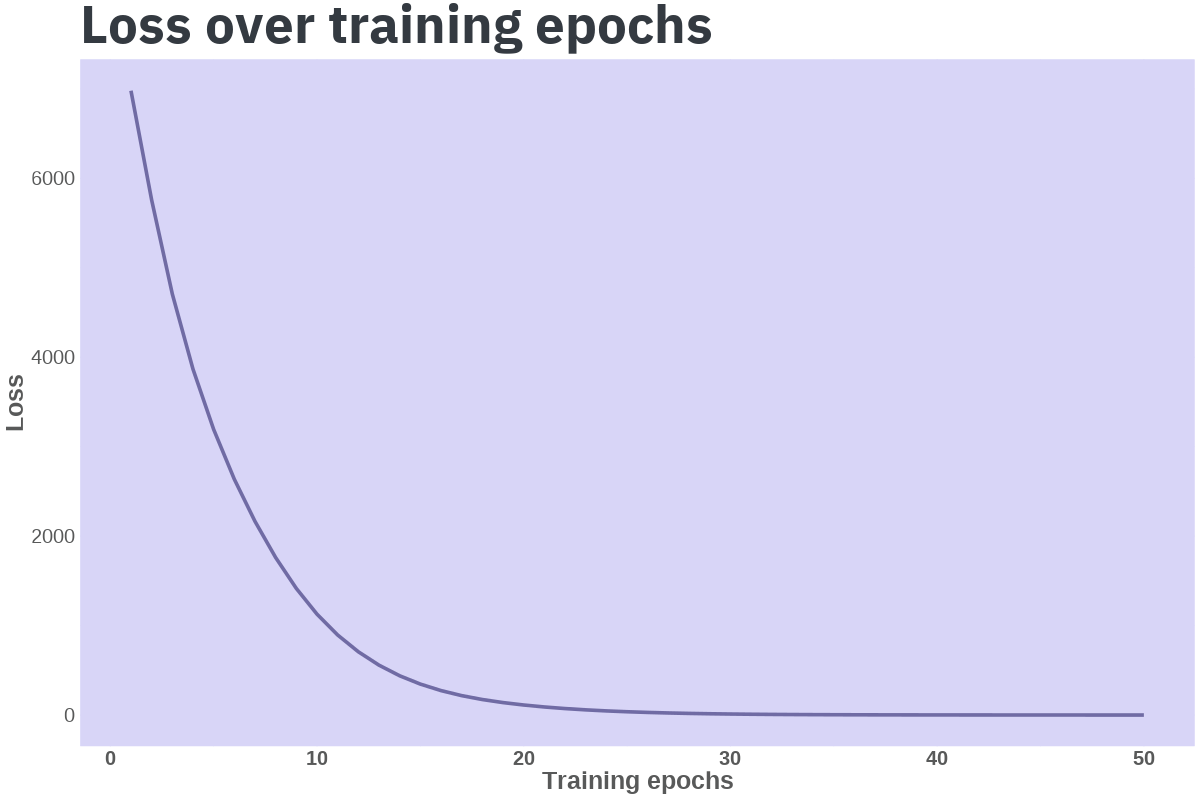

In [111]:
%%R -i losses -h 800 -w 1200

ggplot() +
aes(seq(1, length(losses)), losses) +
geom_line(color = purple_dark, size = 1.7) +
labs(x = 'Training epochs',
     y = "Loss",
     title = 'Loss over training epochs') +
theme_tech

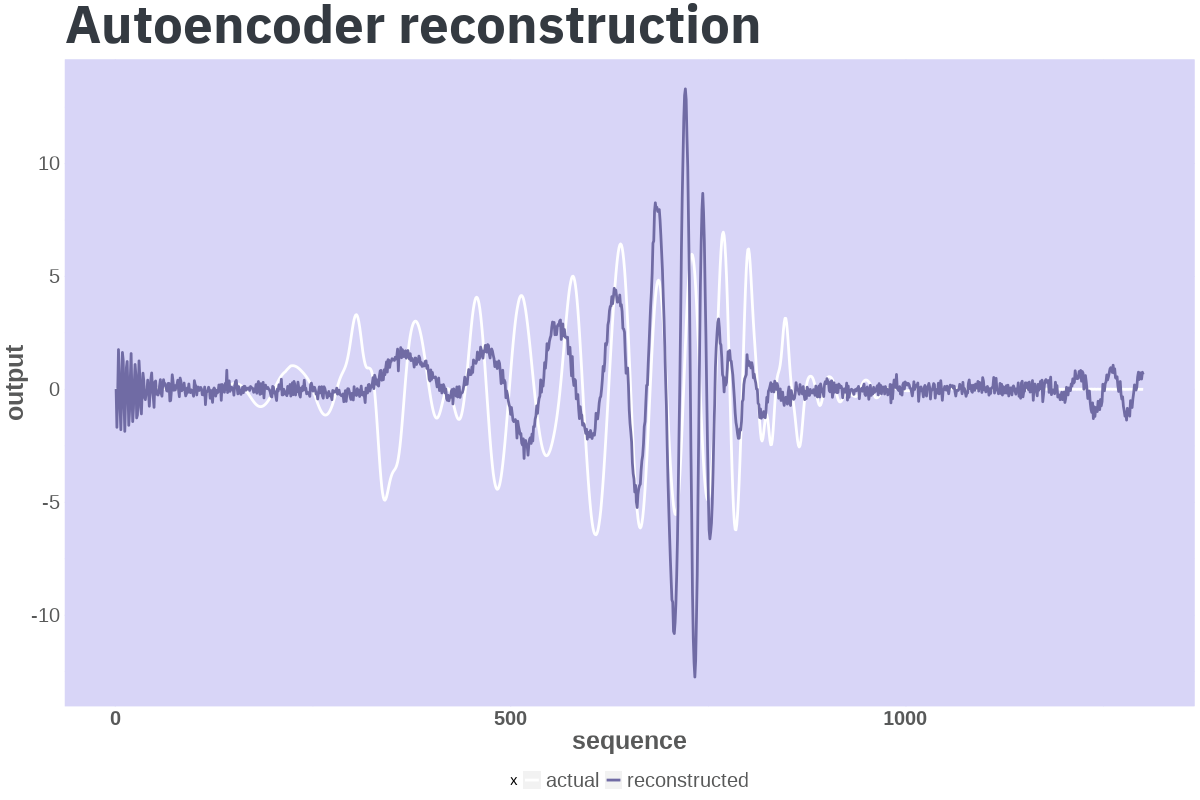

In [95]:
%%R -i x_prime_np -i x_orig -h 800 -w 1200

# Plot reconstructued vs. actual
data.frame(actual = x_orig,
           reconstructed = x_prime_np,
           time = seq(1, length(x_orig))) %>%
gather(actual, reconstructed, key = "x", value = "val") %>%
ggplot(aes(time, val, color = x)) +
geom_line(size = 1.3) +
scale_color_manual(values = c("white", purple_dark)) +
labs(x = 'sequence',
     y = 'output',
     title = 'Autoencoder reconstruction') +
theme_tech

`geom_smooth()` using formula = 'y ~ x'


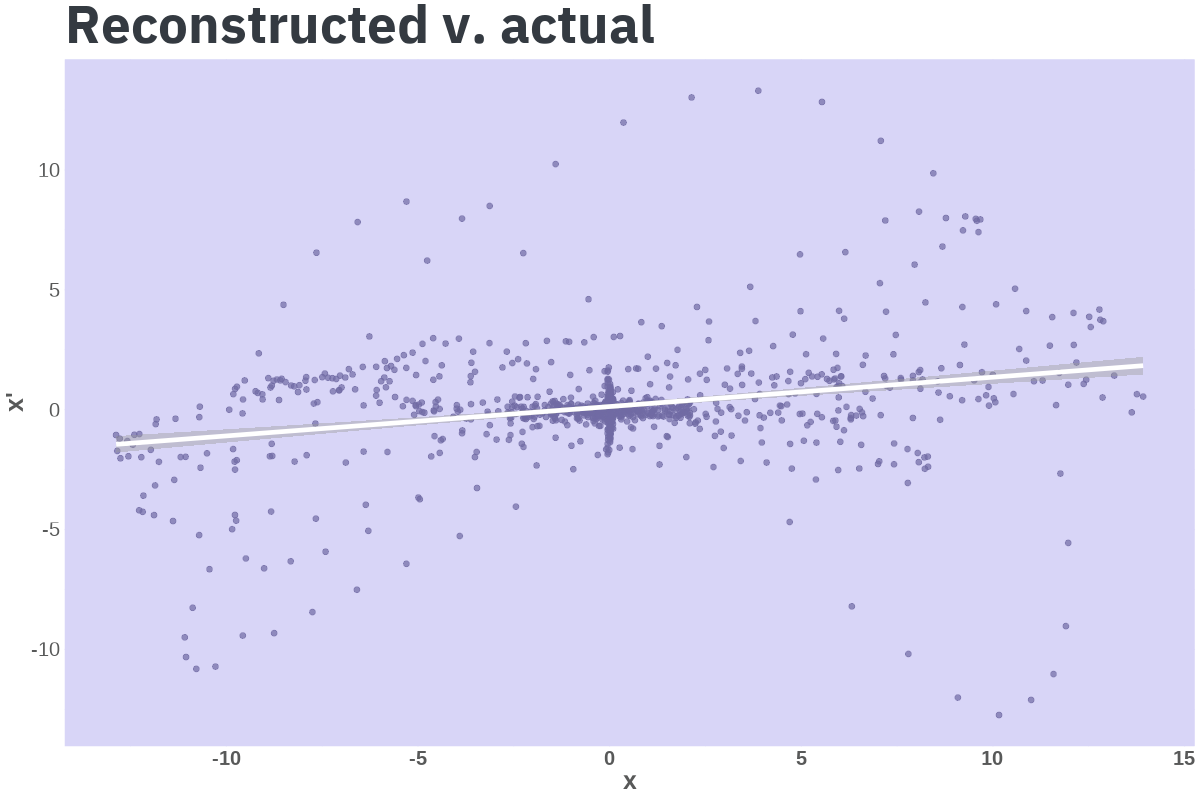

In [107]:
%%R -i x_prime_np -i x_orig -h 800 -w 1200

# Plot reconstructued vs. actual
ggplot() +
aes(x_orig*2, x_prime_np) +
geom_point(color = purple_dark, alpha = 0.7, size = 2.5) +
geom_smooth(method = 'lm', color = "white", size = 2.2) +
labs(y = "x'",
     x = "x",
     title = 'Reconstructed v. actual') +
theme_tech

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


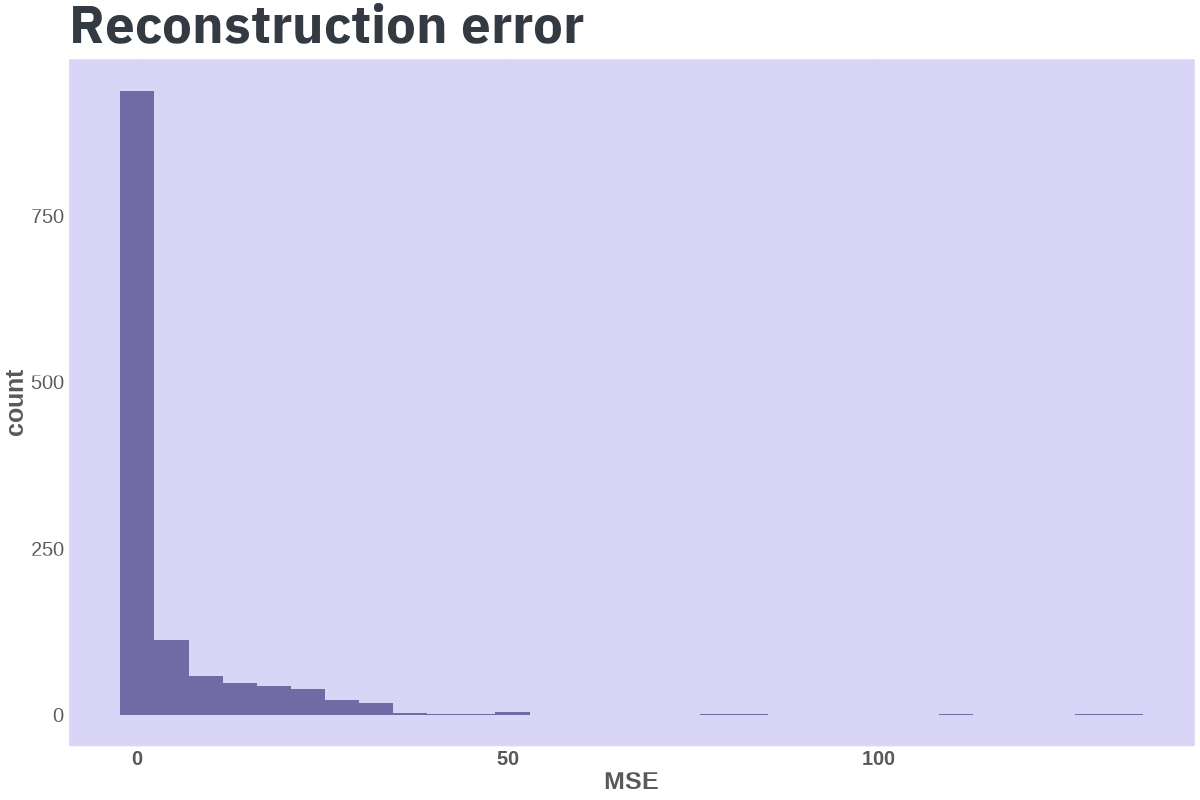

In [114]:
%%R -h 800 -w 1200

auto_mse <- (x_orig - x_prime_np/2)^2

# Plot reconstructued vs. actual
ggplot() +
aes(auto_mse) +
geom_histogram(fill = purple_dark) +
labs(title = 'Reconstruction error',
     x = 'MSE') +
theme_tech